## 目标检测
数据集：pascal_2007

模型：[RetinaNet](https://arxiv.org/abs/1708.02002)

### 1. 数据准备

In [1]:
from fastai.vision import *

In [2]:
path = untar_data(URLs.PASCAL_2007)
path.ls()

[PosixPath('/data00/home/wangchao.zhuanxu/.fastai/data/pascal_2007/models'),
 PosixPath('/data00/home/wangchao.zhuanxu/.fastai/data/pascal_2007/train.json'),
 PosixPath('/data00/home/wangchao.zhuanxu/.fastai/data/pascal_2007/valid.json'),
 PosixPath('/data00/home/wangchao.zhuanxu/.fastai/data/pascal_2007/tmp'),
 PosixPath('/data00/home/wangchao.zhuanxu/.fastai/data/pascal_2007/train'),
 PosixPath('/data00/home/wangchao.zhuanxu/.fastai/data/pascal_2007/test.json'),
 PosixPath('/data00/home/wangchao.zhuanxu/.fastai/data/pascal_2007/test')]

train.json是标注数据，train目录下是图片

In [3]:
train_data = json.load(open(path/"train.json"))

In [4]:
train_data.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

In [5]:
for key in train_data.keys():
    print(key, train_data[key][0])
    print("====")

images {'file_name': '000012.jpg', 'height': 333, 'width': 500, 'id': 12}
====
type i
====
annotations {'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]], 'area': 34104, 'iscrowd': 0, 'image_id': 12, 'bbox': [155, 96, 196, 174], 'category_id': 7, 'id': 1, 'ignore': 0}
====
categories {'supercategory': 'none', 'id': 1, 'name': 'aeroplane'}
====


bbox的格式为，下面通过函数 get_annotations 获取到数据和label

In [6]:
# 通过方便的 get_annotations 函数获取到数据和label
train_images, train_lbl_bbox = get_annotations(path/'train.json')
val_images, val_lbl_bbox = get_annotations(path/'valid.json')

In [7]:
train_images[0], train_lbl_bbox[0]

('000012.jpg', [[[96, 155, 270, 351]], ['car']])

上面返回的 train_lbl_bbox[0] 中 [96, 155, 270, 351] 格式为 ：[左上角，右下角]，然后左上角又是先(y,x)的格式

做数据增强的时候，我们不仅要对原始图片变换，同时对bbox也要做相应变换，另外我们也要考虑倾斜操作带来的bbox变大问题

![](https://cdn-images-1.medium.com/max/800/1*4V4sjFZxn-y2cU9tCJPEUw.png)

下面我们通过 ImageBBox 来创建 bbox，能够在对图像进行变换的时候，重新计算bbox

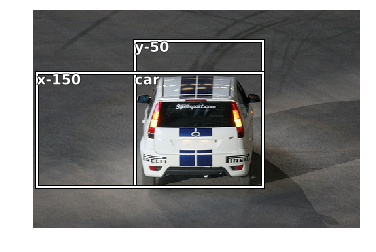

In [8]:
# 单目标数据
img = open_image(path/'train'/train_images[0])
left_top = train_lbl_bbox[0][0][0][:2]
right_bottom =  train_lbl_bbox[0][0][0][2:]
bbox = ImageBBox.create(*img.size, [left_top+right_bottom, 
                                    # y 先减少50
                                    [left_top[0]-50, left_top[1]]+ right_bottom,
                                    # x 减少 150
                                    [left_top[0], left_top[1]-150 ] + right_bottom], labels=[0,1,2], classes=['car','y-50', 'x-150'])
img.show(figsize=(6,4), y=bbox)

ImageBBox.create 函数输入参数分别为 图像的高和宽，然后是bbox位置，类别信息

另外在展示图像的时候，我们是以图像的左上角作为坐标原点的

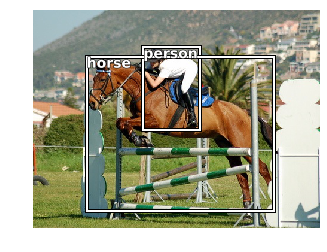

In [9]:
# 多目标数据
img = open_image(path/'train'/train_images[1])
bbox = ImageBBox.create(*img.size, train_lbl_bbox[1][0], [0, 1], classes=['person', 'horse'])
img.show(figsize=(6,4), y=bbox)

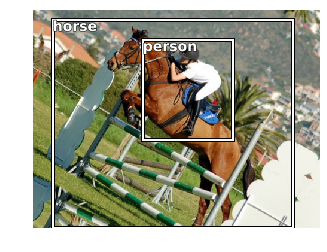

In [10]:
# 做倾斜操作，我们可以看到明显bbox是扩大了的
img = img.rotate(-30)
bbox = bbox.rotate(-30)
img.show(figsize=(6,4), y=bbox)

下一步我们要将数据变为 databunch

In [11]:
# 将数据组成 databatch
images, lbl_bbox = train_images+val_images,train_lbl_bbox+val_lbl_bbox
img2bbox = dict(zip(images, lbl_bbox))
get_y_func = lambda o:img2bbox[o.name]

def get_data(bs, size):
    src = ObjectItemList.from_folder(path/'train')
    src = src.split_by_files(val_images)
    src = src.label_from_func(get_y_func)
    src = src.transform(get_transforms(), size=size, tfm_y=True)
    return src.databunch(path=path, bs=bs, collate_fn=bb_pad_collate)

此处 bb_pad_collate 的作用是对 label 进行补齐操作，因为每个图片标注的bbox个数不同

补齐策略：pad_first

In [12]:
# batch_size = 64, 图片大小 128
data = get_data(64,128)

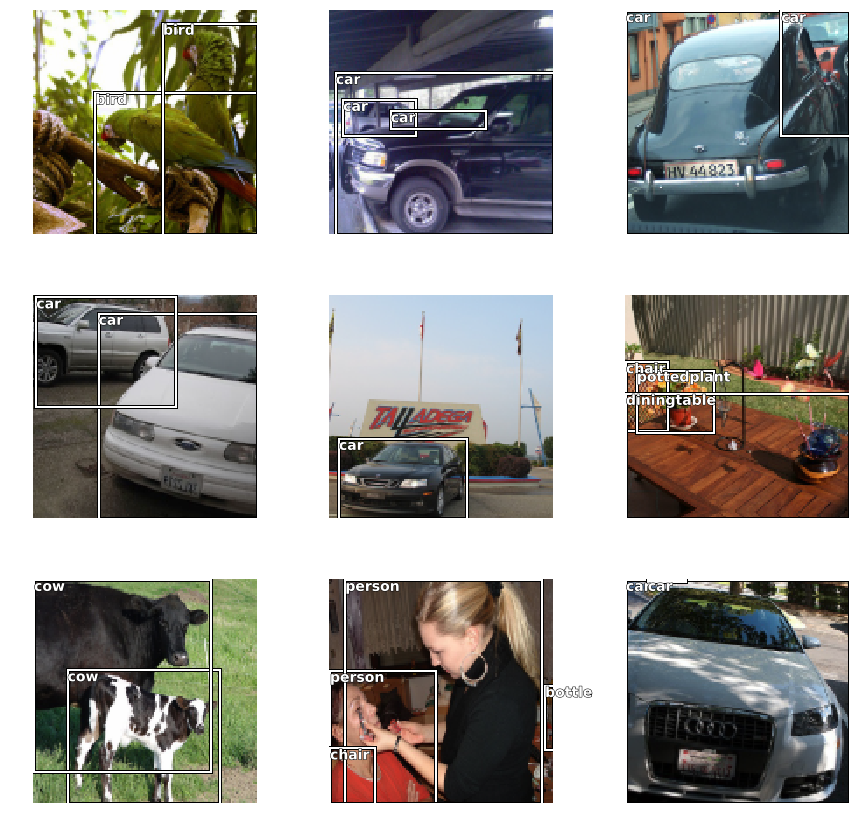

In [13]:
data.show_batch(rows=3)

## anchor
第一步我们先来建立grid，将正方形进行划分

In [14]:
def create_grid(size):
    "Create a grid of a given `size`."
    H, W = size if is_tuple(size) else (size,size)
    grid = FloatTensor(H, W, 2)
    linear_points = torch.linspace(-1+1/W, 1-1/W, W) if W > 1 else tensor([0.])
    # 外积 torch.ger
    grid[:, :, 1] = torch.ger(torch.ones(H), linear_points).expand_as(grid[:, :, 0])
    linear_points = torch.linspace(-1+1/H, 1-1/H, H) if H > 1 else tensor([0.])
    grid[:, :, 0] = torch.ger(linear_points, torch.ones(W)).expand_as(grid[:, :, 1])
    return grid.view(-1,2)

In [15]:
def show_anchors(ancs, size):
    _,ax = plt.subplots(1,1, figsize=(5,5))
    ax.set_xticks(np.linspace(-1,1, size[1]+1))
    ax.set_yticks(np.linspace(-1,1, size[0]+1))
    ax.grid()
    ax.scatter(ancs[:,1], ancs[:,0]) # ancs 中 (y, x) 格式
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xlim(-1,1)
    ax.set_ylim(1,-1) #-1 is top, 1 is bottom
    for i, (x, y) in enumerate(zip(ancs[:, 1], ancs[:, 0])): ax.annotate(i, xy = (x,y))

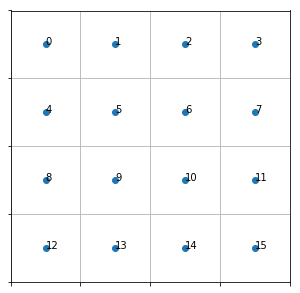

In [16]:
H = 4
W = 4
size = (H,W)
show_anchors(create_grid(size), size)

In [17]:
def create_anchors(sizes, ratios, scales, flatten=True):
    "Create anchor of `sizes`, `ratios` and `scales`."
    # s 是缩放，r 是 height/width, s * math.sqrt(r) / s*math.sqrt(1/r) = r
    # aspects 是缩放后的 height,width     
    aspects = [[[s*math.sqrt(r), s*math.sqrt(1/r)] for s in scales] for r in ratios]
    aspects = torch.tensor(aspects).view(-1,2)
    anchors = []
    for h,w in sizes:
        # 在 (h,w)下1的单位缩放到 (2,2), (1,1) -> (2/h, 2/h)
        # 乘以 4 是因为我们假设在 (h,w) 下，anchor 大小是 4*4
        sized_aspects = 4 * (aspects * torch.tensor([2/h,2/w])).unsqueeze(0)
        # create_grid((h,w)) 返回 (n_grid, 2)
        # base_grid 在 每个点上有 a 个 anchor， 每个anchor长宽是 aspects
        base_grid = create_grid((h,w)).unsqueeze(1)
        # n 是所有点的个数，a 则是 anchor 的个数         
        n,a = base_grid.size(0),aspects.size(0)
        # 中心点 （y,x）高，宽（height, width）        
        ancs = torch.cat([base_grid.expand(n,a,2), sized_aspects.expand(n,a,2)], 2)
        anchors.append(ancs.view(h,w,a,4)) # 4 是 4个参数，中心点 （y,x）高，宽（height, width） 
    return torch.cat([anc.view(-1,4) for anc in anchors],0) if flatten else anchors

In [18]:
ratios = [1/2,1,2]
scales = [1,2**(-1/3), 2**(-2/3)] 
#Paper used [1,2**(1/3), 2**(2/3)] but a bigger size (600) too, so the largest feature map gave anchors that cover less of the image.
sizes = [(2**i,2**i) for i in range(5)]
sizes.reverse() #Predictions come in the order of the smallest feature map to the biggest
anchors = create_anchors(sizes, ratios, scales)

In [19]:
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from cycler import cycler

def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

num_color = 12
cmap = get_cmap(num_color)
color_list = [cmap(float(x)) for x in range(num_color)]

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [20]:
def show_boxes(boxes):
    "Show the `boxes` (size by 4)"
    _, ax = plt.subplots(1,1, figsize=(5,5))
    ax.set_xlim(-1,1)
    ax.set_ylim(1,-1)
    for i, bbox in enumerate(boxes):
        bb = bbox.numpy()
        rect = [bb[1]-bb[3]/2, bb[0]-bb[2]/2, bb[3], bb[2]]
        draw_rect(ax, rect, color=color_list[i%num_color])
        draw_text(ax, [bb[1]-bb[3]/2,bb[0]-bb[2]/2], str(i), color=color_list[i%num_color])

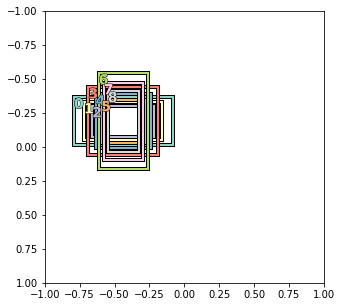

In [21]:
show_boxes(anchors[900:909])

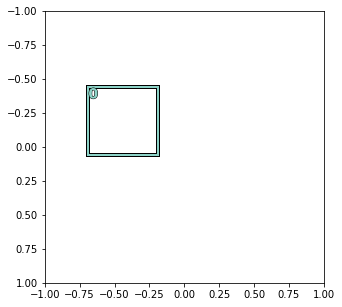

In [22]:
# ratios = [1/2,1,2] # height/width
# scales = [1,2**(-1/3), 2**(-2/3)] # 缩放比
# 展示 height/width=1, scales = 1,
show_boxes(anchors[903:904])

In [23]:
# 我们可以看到在 h,w=16,16情况下，长度为4的anchor在2，2下其实就是 2/4 = 0.5 大小
anchors[903:904] 

tensor([[-0.1875, -0.4375,  0.5000,  0.5000]])

下面我们要将网络预测出来的值，转换为预测的bbox


```
center = [p_y * anc_h + anc_y, p_x * anc_w + anc_x]
height = anc_h * exp(p_h)
width  = anc_w * exp(p_w)
```

anchor 值 (anc_y, anc_x, anc_h, anc_w) 中心点位置，宽高

预测出来的4个值 （p_y,p_x,p_h,p_w）

真实值是先中心点平移，再缩放

下面一个函数是输入预测值 和 anchor，给出实际anchor

In [24]:
def activ_to_bbox(acts, anchors, flatten=True):
    "Extrapolate bounding boxes on anchors from the model activations."
    if flatten:
        #Can't remember where those scales come from, but they help regularize
        # 预测出来的值，整体乘以一个因子
        acts.mul_(acts.new_tensor([[0.1, 0.1, 0.2, 0.2]]))
        centers = anchors[...,2:] * acts[...,:2] + anchors[...,:2]
        sizes = anchors[...,2:] * torch.exp(acts[...,:2])
        return torch.cat([centers, sizes], -1)
    else: return [activ_to_bbox(act,anc) for act,anc in zip(acts, anchors)]
    return res

In [25]:
size=(3,4)
# 中心点位置
anchors = create_grid(size)
# 中心点 + 长宽
# 因为长和宽都是 [-1，1]，那每个都是2，然后这个是每个格子的大小
anchors = torch.cat([anchors, torch.tensor([2/size[0],2/size[1]]).expand_as(anchors)], 1)
# 模拟预测值，每个位置一个预测值
activations = torch.randn(size[0]*size[1], 4) * 0.1
bboxes = activ_to_bbox(activations, anchors)

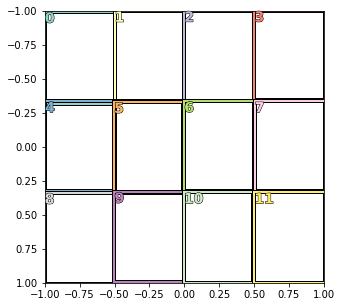

In [26]:
show_boxes(bboxes)

下面定义辅助函数：

将 center/size format `boxes` to top/left bottom/right corners.

In [27]:
def cthw2tlbr(boxes):
    "Convert center/size format `boxes` to top/left bottom/right corners."
    top_left = boxes[:,:2] - boxes[:,2:]/2
    bot_right = boxes[:,:2] + boxes[:,2:]/2
    return torch.cat([top_left, bot_right], 1)

下面我们求预测出来的anchors和ground truth之间的交

In [28]:
def intersection(anchors, targets):
    "Compute the sizes of the intersections of `anchors` by `targets`."
    ancs, tgts = cthw2tlbr(anchors), cthw2tlbr(targets)
    a, t = ancs.size(0), tgts.size(0)
    ancs, tgts = ancs.unsqueeze(1).expand(a,t,4), tgts.unsqueeze(0).expand(a,t,4)
    top_left_i = torch.max(ancs[...,:2], tgts[...,:2])
    bot_right_i = torch.min(ancs[...,2:], tgts[...,2:])
    sizes = torch.clamp(bot_right_i - top_left_i, min=0) 
    return sizes[...,0] * sizes[...,1]

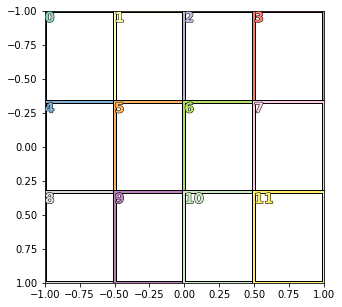

In [29]:
# 这个是之前预测出来的12个anchor
show_boxes(anchors)

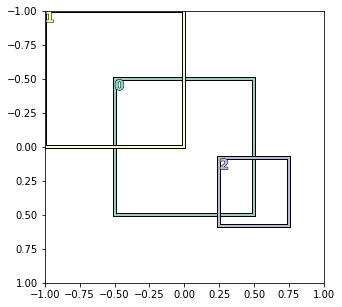

In [30]:
targets = torch.tensor([[0.,0.,1.,1.], [-0.5,-0.5,1.,1.], [1/3,0.5,0.5,0.5]])
show_boxes(targets)

In [31]:
# 我们计算每个anchor与target的相交面积
intersection(anchors, targets)

tensor([[0.0000, 0.3333, 0.0000],
        [0.0833, 0.3333, 0.0000],
        [0.0833, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.1667, 0.0000],
        [0.3333, 0.1667, 0.0000],
        [0.3333, 0.0000, 0.0625],
        [0.0000, 0.0000, 0.0625],
        [0.0000, 0.0000, 0.0000],
        [0.0833, 0.0000, 0.0000],
        [0.0833, 0.0000, 0.0625],
        [0.0000, 0.0000, 0.0625]])

下面计算iou

In [32]:
def IoU_values(anchors, targets):
    "Compute the IoU values of `anchors` by `targets`."
    inter = intersection(anchors, targets)
    anc_sz, tgt_sz = anchors[:,2] * anchors[:,3], targets[:,2] * targets[:,3]
    union = anc_sz.unsqueeze(1) + tgt_sz.unsqueeze(0) - inter
    return inter/(union+1e-8)

In [33]:
IoU_values(anchors, targets)

tensor([[0.0000, 0.3333, 0.0000],
        [0.0667, 0.3333, 0.0000],
        [0.0667, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.1429, 0.0000],
        [0.3333, 0.1429, 0.0000],
        [0.3333, 0.0000, 0.1200],
        [0.0000, 0.0000, 0.1200],
        [0.0000, 0.0000, 0.0000],
        [0.0667, 0.0000, 0.0000],
        [0.0667, 0.0000, 0.1200],
        [0.0000, 0.0000, 0.1200]])

上面tensor，每一行都是一个anchor和所有target之间的iou值

现在计算出了每个anchor和target之间的iou，我们下面做如下的规则：

1. 我们取anchor和target最大iou的值
2. 如果overlap小于0.4，则认为背景，归为那个分类
3. 如果大于0.5，则认为是该分类
4. 0，4~0.5之间我们忽略

In [34]:
def match_anchors(anchors, targets, match_thr=0.5, bkg_thr=0.4):
    "Match `anchors` to targets. -1 is match to background, -2 is ignore."
    matches = anchors.new(anchors.size(0)).zero_().long() - 2
    if targets.numel() == 0: return matches
    # ious, shape (anchor_len,target_len)     
    ious = IoU_values(anchors, targets)
    vals,idxs = torch.max(ious,1)
    matches[vals < bkg_thr] = -1
    matches[vals > match_thr] = idxs[vals > match_thr]
    #Overwrite matches with each target getting the anchor that has the max IoU.
    #vals,idxs = torch.max(ious,0)
    #If idxs contains repetition, this doesn't bug and only the last is considered.
    #matches[idxs] = targets.new_tensor(list(range(targets.size(0)))).long()
    return matches

In [35]:
# 我们的例子中iou都小于0.4，所有都是背景
match_anchors(anchors, targets)

tensor([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

In [36]:
size=(3,4)
anchors = create_grid(size)
anchors = torch.cat([anchors, torch.tensor([2/size[0],2/size[1]]).expand_as(anchors)], 1)
activations = 0.1 * torch.randn(size[0]*size[1], 4)
bboxes = activ_to_bbox(activations, anchors)
# 直接匹配
match_anchors(anchors,bboxes)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [37]:
size = (2,2)
anchors = create_grid(size)
anchors = torch.cat([anchors, torch.tensor([2/size[0],2/size[1]]).expand_as(anchors)], 1)
targets = anchors.clone()
anchors = torch.cat([anchors, torch.tensor([[-0.5,0.,1.,1.8]])], 0)
match_anchors(anchors,targets)

tensor([ 0,  1,  2,  3, -2])

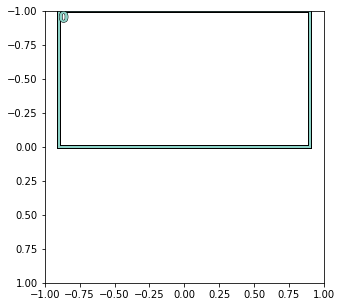

In [38]:
show_boxes([anchors[-1]]) 

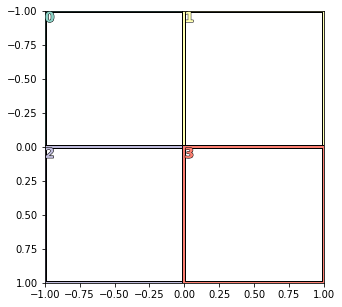

In [39]:
show_boxes(targets)

In [40]:
IoU_values(anchors, targets)

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000],
        [0.4737, 0.4737, 0.0000, 0.0000]])

定义将 top/left bottom/right format `boxes` to center/size corners.

In [41]:
def tlbr2cthw(boxes):
    "Convert top/left bottom/right format `boxes` to center/size corners."
    center = (boxes[:,:2] + boxes[:,2:])/2
    sizes = boxes[:,2:] - boxes[:,:2]
    return torch.cat([center, sizes], 1)

定义将bbox格式转换为相对anchor的格式

In [42]:
def bbox_to_activ(bboxes, anchors, flatten=True):
    "Return the target of the model on `anchors` for the `bboxes`."
    if flatten:
        t_centers = (bboxes[...,:2] - anchors[...,:2]) / anchors[...,2:] 
        t_sizes = torch.log(bboxes[...,2:] / anchors[...,2:] + 1e-8) 
        return torch.cat([t_centers, t_sizes], -1).div_(bboxes.new_tensor([[0.1, 0.1, 0.2, 0.2]]))
    else: return [activ_to_bbox(act,anc) for act,anc in zip(acts, anchors)]
    return res

定义one-hot转换函数，0认为是背景

In [146]:
def encode_class(idxs, n_classes):
    # 此处实验完后发现，我们希望模型输出的其实是除去background的分类
    # 在预测时，都是一个二分类预测，是或者不是，然后不会单独预测是否是background，
    # 所有我们要去除类别为0的分类
    target = idxs.new_zeros(len(idxs), n_classes).float()
    mask = idxs != 0
    i1s = LongTensor(list(range(len(idxs))))
    target[i1s[mask],idxs[mask]-1] = 1
    return target
# def encode_class(idxs, n_classes):
#     target = idxs.new_zeros(len(idxs), n_classes).float()
# #     mask = idxs != 0
#     i1s = torch.LongTensor(list(range(len(idxs))))
#     # target[i1s[mask], idxs[mask] - 1] = 1
#     target[range(len(idxs)), idxs] = 1
#     return target

In [75]:
encode_class(LongTensor([1,2,0,1,3]),4)

tensor([[0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.]])

In [117]:
# 21个类别，包括了background
data.c, data.classes[:4]

(21, ['background', 'aeroplane', 'bicycle', 'bird'])

In [115]:
data.valid_ds.y[0].data, data.valid_ds.y[0].labels

((tensor([[-0.7839, -0.7160,  0.4792,  0.9840],
          [-0.0582, -1.0000,  0.0582, -0.7680]]), array([19,  7])),
 array([Category train, Category car], dtype=object))

In [118]:
data.classes[7]

'car'

## loss函数
loss分为两类：

- 分类误差：采样 focal loss,因为数据偏态严重，前景样本特别多，所以采用抑制确定性误差
- 回归误差：只计算iou>0.5的才计算 l1 loss

In [45]:
class RetinaNetFocalLoss(nn.Module):

    def __init__(self, gamma: float = 2., alpha: float = 0.25, pad_idx: int = 0, scales: Collection[float] = None,
                 ratios: Collection[float] = None, reg_loss: LossFunction = F.smooth_l1_loss):
        super().__init__()
        self.gamma, self.alpha, self.pad_idx, self.reg_loss = gamma, alpha, pad_idx, reg_loss
        self.scales = ifnone(scales, [1, 2 ** (-1 / 3), 2 ** (-2 / 3)])
        self.ratios = ifnone(ratios, [1 / 2, 1, 2])

    def _change_anchors(self, sizes: Sizes) -> bool:
        if not hasattr(self, 'sizes'):
            return True
        for sz1, sz2 in zip(self.sizes, sizes):
            if sz1[0] != sz2[0] or sz1[1] != sz2[1]:
                return True
        return False

    def _create_anchors(self, sizes: Sizes, device: torch.device):
        self.sizes = sizes
        # 在不同层的 feature map 上创建 anchor
        self.anchors = create_anchors(sizes, self.ratios, self.scales).to(device)

    def _unpad(self, bbox_tgt, clas_tgt):
        i = torch.min(torch.nonzero(clas_tgt - self.pad_idx))
        return tlbr2cthw(bbox_tgt[i:]), clas_tgt[i:] - 1 + self.pad_idx

    def _focal_loss(self, clas_pred, clas_tgt):
        encoded_tgt = encode_class(clas_tgt, clas_pred.size(1))
        ps = torch.sigmoid(clas_pred.detach())
        weights = encoded_tgt * (1 - ps) + (1 - encoded_tgt) * ps
        alphas = (1 - encoded_tgt) * self.alpha + encoded_tgt * (1 - self.alpha)
        weights.pow_(self.gamma).mul_(alphas)
        clas_loss = F.binary_cross_entropy_with_logits(clas_pred, encoded_tgt, weights, reduction='sum')
        return clas_loss

    def _one_loss(self, clas_pred, bbox_pred, clas_tgt, bbox_tgt):
        # clas_preds (batch_size, class, 2)
        bbox_tgt, clas_tgt = self._unpad(bbox_tgt, clas_tgt)
        # 哪几个 anchor 可以映射到tgt
        matches = match_anchors(self.anchors, bbox_tgt)
        bbox_mask = matches >= 0
        if bbox_mask.sum() != 0:
            bbox_pred = bbox_pred[bbox_mask]
            bbox_tgt = bbox_tgt[matches[bbox_mask]]
            bb_loss = self.reg_loss(bbox_pred, bbox_to_activ(bbox_tgt, self.anchors[bbox_mask]))
        else:
            bb_loss = 0.
        # 全都加1，现在0表示背景            
        matches.add_(1)
        clas_tgt = clas_tgt + 1
        clas_mask = matches >= 0
        clas_pred = clas_pred[clas_mask]
        clas_tgt = torch.cat([clas_tgt.new_zeros(1).long(), clas_tgt])
        clas_tgt = clas_tgt[matches[clas_mask]]
        return bb_loss + self._focal_loss(clas_pred, clas_tgt) / torch.clamp(bbox_mask.sum(), min=1.)

    def forward(self, output, bbox_tgts, clas_tgts):
        # clas_preds (batch_size, class, 2)
        clas_preds, bbox_preds, sizes = output
        if self._change_anchors(sizes):
            self._create_anchors(sizes, clas_preds.device)
        n_classes = clas_preds.size(2)
        return sum([self._one_loss(cp, bp, ct, bt)
                    for (cp, bp, ct, bt) in zip(clas_preds, bbox_preds, clas_tgts, bbox_tgts)]) / clas_tgts.size(0)


class SigmaL1SmoothLoss(nn.Module):

    def forward(self, output, target):
        reg_diff = torch.abs(target - output)
        reg_loss = torch.where(torch.le(reg_diff, 1 / 9), 4.5 * torch.pow(reg_diff, 2), reg_diff - 1 / 18)
        return reg_loss.mean()

In [46]:
# data.classes, len(data.classes) # 其中0是background

## 模型
论文：[RetinaNet](https://arxiv.org/abs/1708.02002)


In [47]:
from fastai.vision.models.unet import _get_sfs_idxs, model_sizes, hook_outputs

class LateralUpsampleMerge(nn.Module):
    """Merge the features coming from the downsample path (in `hook`) with the upsample path."""

    def __init__(self, ch, ch_lat, hook):
        super().__init__()
        self.hook = hook
        # 统一将输入转换到 ch=256
        self.conv_lat = conv2d(ch_lat, ch, ks=1, bias=True)

    def forward(self, x):
        # interpolate 将 x 的 feature_map size 转换到与 hook 大小一致
        return self.conv_lat(self.hook.stored) + F.interpolate(x, self.hook.stored.shape[-2:], mode='nearest')


class RetinaNet(nn.Module):
    """Implements RetinaNet from https://arxiv.org/abs/1708.02002"""

    def __init__(self, encoder: nn.Module, n_classes, final_bias=0., chs=256, n_anchors=9, flatten=True):
        super().__init__()
        self.n_classes, self.flatten = n_classes, flatten
        imsize = (256, 256)
        # 获取模型每一层的输出, (batch_size, channel, width, height)
        sfs_szs = model_sizes(encoder, size=imsize)
        # 根据 feature_map 尺寸获取到变化的地方
        # [6, 5, 4, 2]
        sfs_idxs = list(reversed(_get_sfs_idxs(sfs_szs)))
        self.sfs = hook_outputs([encoder[i] for i in sfs_idxs])
        self.encoder = encoder
        # c5:(batch_size, input_channel, size=8, size=8) => p5 (batch_size, chs=256, size, size)
        self.c5top5 = conv2d(sfs_szs[-1][1], chs, ks=1, bias=True)
        # c5:(batch_size, input_channel, size, size) => p6 (batch_size, chs=256, size/2, size/2)
        self.c5top6 = conv2d(sfs_szs[-1][1], chs, stride=2, bias=True)
        # p6:(batch_size, chs=256, size/2, size/2) => p7 (batch_size, chs=256, size/4=2, size/4=2)
        self.p6top7 = nn.Sequential(nn.ReLU(), conv2d(chs, chs, stride=2, bias=True))
        # 倒数层的 c5 已经转换到了 p5，项目是将 p5 -> p4 + c4
        # self.merges = nn.ModuleList([LateralUpsampleMerge(chs, sfs_szs[idx][1], hook)
        #                              for idx, hook in zip(sfs_idxs[-2:-4:-1], self.sfs[-2:-4:-1])])
        self.merges = nn.ModuleList([LateralUpsampleMerge(chs, sfs_szs[idx][1], hook)
                                     for idx, hook in zip(sfs_idxs[0:2:1], self.sfs[0:2:1])])
        self.smoothers = nn.ModuleList([conv2d(chs, chs, 3, bias=True) for _ in range(3)])

        self.classifier = self._head_subnet(n_classes, n_anchors, final_bias, chs=chs)
        self.box_regressor = self._head_subnet(4, n_anchors, 0., chs=chs)

    def _head_subnet(self, n_classes, n_anchors, final_bias=0., n_conv=4, chs=256):
        # 默认4层卷积 256->256，然后最后接具体的分类
        """Helper function to create one of the subnet for regression/classification."""
        layers = [conv_layer(chs, chs, bias=True, norm_type=None) for _ in range(n_conv)]
        layers += [conv2d(chs, n_classes * n_anchors, bias=True)]
        layers[-1].bias.data.zero_().add_(final_bias)
        layers[-1].weight.data.fill_(0)
        return nn.Sequential(*layers)

    def _apply_transpose(self, func, p_states, n_classes):
        # Final result of the classifier/regressor is bs * (k * n_anchors) * h * w
        # We make it bs * h * w * n_anchors * k then flatten in bs * -1 * k so we can contenate
        # all the results in bs * anchors * k (the non flatten version is there for debugging only)
        if not self.flatten:
            # bs, h, w
            sizes = [[p.size(0), p.size(2), p.size(3)] for p in p_states]
            # bs, h, w, (k * n_anchors) -> (bs , h , w, n_anchors, k)
            return [func(p).permute(0, 2, 3, 1).view(*sz, -1, n_classes) for p, sz in zip(p_states, sizes)]
        else:
            # bs, h, w, (k * n_anchors) -> (bs , h * w * n_anchors, k)
            return torch.cat(
                [func(p).permute(0, 2, 3, 1).contiguous().view(p.size(0), -1, n_classes) for p in p_states], 1)

    def forward(self, x):
        c5 = self.encoder(x)
        p5 = self.c5top5(c5.clone())
        p6 = self.c5top6(c5)
        p7 = self.p6top7(p6)
        p_states = [p5, p6, p7]

        # p_states [p5, p6, p7]
        #           (8*8, 4*4, 2*2)
        for merge in self.merges:
            # 将前一层的p反卷积，然后再将其加上c层特征
            p_states = [merge(p_states[0])] + p_states
        # p_states [p3, p4,  p5, p6, p7]
        #           [32*32, 16*16, 8*8, 4*4, 2*2]
        for i, smooth in enumerate(self.smoothers[:3]):
            # 对前几层特征再加一个卷积做特征加强
            p_states[i] = smooth(p_states[i])
        return [self._apply_transpose(self.classifier, p_states, self.n_classes),
                self._apply_transpose(self.box_regressor, p_states, 4),
                [[p.size(2), p.size(3)] for p in p_states]]

    def __del__(self):
        if hasattr(self, "sfs"):
            self.sfs.remove()


## 定义learner

In [147]:
encoder = create_body(models.resnet50, cut=-2)
model = RetinaNet(encoder, data.c, final_bias=-4)
crit = RetinaNetFocalLoss(scales=scales, ratios=ratios)
learn = Learner(data, model, loss_func=crit)

In [148]:
def retina_net_split(model):
    groups = [list(model.encoder.children())[:6], list(model.encoder.children())[6:]]
    return groups + [list(model.children())[1:]]

In [149]:
learn = learn.split(retina_net_split)

In [150]:
learn.freeze()

In [151]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


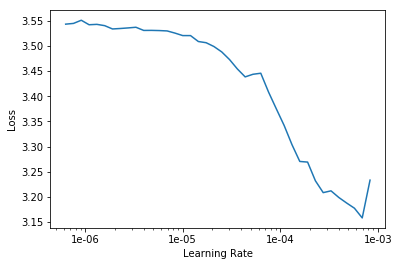

In [152]:
learn.recorder.plot()

In [153]:
learn.fit_one_cycle(5, 1e-4)

epoch,train_loss,valid_loss,time
0,2.840008,2.215219,00:40
1,2.234887,2.066945,00:41
2,1.908113,1.724491,00:41
3,1.681244,1.641608,00:41
4,1.545845,1.601532,00:41


In [154]:
learn.save('stage1-128',return_path=True)

PosixPath('/data00/home/wangchao.zhuanxu/.fastai/data/pascal_2007/models/stage1-128.pth')

In [155]:
learn.unfreeze()

In [156]:
learn.fit_one_cycle(10, slice(1e-6, 5e-5))

epoch,train_loss,valid_loss,time
0,1.425561,1.543643,00:42
1,1.404071,1.531360,00:42
2,1.365307,1.432567,00:42
3,1.309000,1.400246,00:42
4,1.241779,1.392356,00:42
5,1.187223,1.341264,00:42
6,1.125020,1.268757,00:42
7,1.078409,1.227100,00:42
8,1.045196,1.240630,00:42
9,1.027255,1.231921,00:42


In [158]:
learn.save('stage2-128')

变换图片大小

In [121]:
learn.load('stage2-128')

/data00/home/wangchao.zhuanxu/anaconda3/envs/bert/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type LateralUpsampleMerge. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/data00/home/wangchao.zhuanxu/anaconda3/envs/bert/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type RetinaNetFocalLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/data00/home/wangchao.zhuanxu/anaconda3/envs/bert/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type RetinaNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Learner(data=ImageDataBunch;

Train: LabelList (2501 items)
x: ObjectItemList
Image (3, 192, 192),Image (3, 192, 192),Image (3, 192, 192),Image (3, 192, 192),Image (3, 192, 192)
y: ObjectCategoryList
ImageBBox (192, 192),ImageBBox (192, 192),ImageBBox (192, 192),ImageBBox (192, 192),ImageBBox (192, 192)
Path: /data00/home/wangchao.zhuanxu/.fastai/data/pascal_2007/train;

Valid: LabelList (2510 items)
x: ObjectItemList
Image (3, 192, 192),Image (3, 192, 192),Image (3, 192, 192),Image (3, 192, 192),Image (3, 192, 192)
y: ObjectCategoryList
ImageBBox (192, 192),ImageBBox (192, 192),ImageBBox (192, 192),ImageBBox (192, 192),ImageBBox (192, 192)
Path: /data00/home/wangchao.zhuanxu/.fastai/data/pascal_2007/train;

Test: None, model=RetinaNet(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size

In [122]:
learn.data = get_data(32,192)

In [123]:
learn.freeze()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


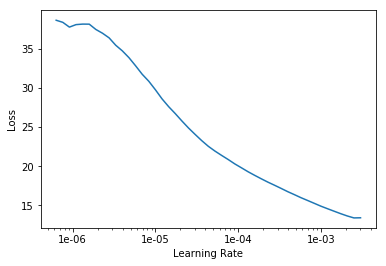

In [124]:
learn.recorder.plot()

In [125]:
learn.fit_one_cycle(5, 1e-5)

epoch,train_loss,valid_loss,time
0,11.939693,3.910940,00:58
1,4.254043,2.441744,00:58
2,2.625506,2.233115,00:58
3,2.182638,2.186946,00:57
4,2.049605,2.182182,00:58


In [126]:
learn.save('stage1-192')

In [127]:
learn.unfreeze()

In [128]:
learn.fit_one_cycle(10, slice(1e-6, 5e-5))

epoch,train_loss,valid_loss,time
0,1.973119,2.000470,01:02
1,1.859785,1.892445,01:02
2,1.747560,1.816225,01:02
3,1.623169,1.630669,01:02
4,1.490954,1.617860,01:02
5,1.374033,1.482929,01:02
6,1.310672,1.437987,01:02
7,1.237762,1.416615,01:03
8,1.191777,1.415301,01:02
9,1.177675,1.387635,01:02


In [129]:
learn.save('stage2-192')

## 结果

In [159]:
img,target = next(iter(data.valid_dl))
with torch.no_grad():
    output = learn.model(img)

In [160]:
# 每个grid都有9个anchor
sum([i[0]*i[1] for i in output[2]]) * 9

3069

In [161]:
# 每个图像都有 3096 个anchor
output[0].shape, output[1].shape, output[2]

(torch.Size([64, 3069, 21]),
 torch.Size([64, 3069, 4]),
 [[16, 16], [8, 8], [4, 4], [2, 2], [1, 1]])

In [162]:
def process_output(output, i, detect_thresh=0.25):
    "Process `output[i]` and return the predicted bboxes above `detect_thresh`."
    clas_pred,bbox_pred,sizes = output[0][i], output[1][i], output[2]
    #  torch.Size([3069, 21]) torch.Size([3069, 4])
    # 根据 预测 sizes 创建 anchors
    anchors = create_anchors(sizes, ratios, scales).to(clas_pred.device)
    # 根据 anchors 和 预测 返回真实的 bbox
    bbox_pred = activ_to_bbox(bbox_pred, anchors)
    clas_pred = torch.sigmoid(clas_pred)
    # 多类别预测，取最大的可能性，即从每个anchor的预测中取最大可能的预测
    # 每个anchor都取类别预测中最大的作为预测值     
    detect_mask = clas_pred.max(1)[0] > detect_thresh
    bbox_pred, clas_pred = bbox_pred[detect_mask], clas_pred[detect_mask]
    
    if clas_pred.numel() == 0: return [],[],[]
    # 设置最大最小值     
    # 如果     detect_mask == none，会有问题, TODO:fix 
    bbox_pred = tlbr2cthw(torch.clamp(cthw2tlbr(bbox_pred), min=-1, max=1))    
    scores, preds = clas_pred.max(1)
    return bbox_pred, scores, preds

def _draw_outline(o:Patch, lw:int):
    "Outline bounding box onto image `Patch`."
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax:plt.Axes, b:Collection[int], color:str='white', text=None, text_size=14):
    "Draw bounding box on `ax`."
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    _draw_outline(patch, 4)
    if text is not None:
        patch = ax.text(*b[:2], text, verticalalignment='top', color=color, fontsize=text_size, weight='bold')
        _draw_outline(patch,1)  

In [179]:
def nms(boxes, scores, thresh=0.2):
    if len(scores) == 0:
        return []
    idx_sort = scores.argsort(descending=True)
    boxes, scores = boxes[idx_sort], scores[idx_sort]
    to_keep, indexes = [], torch.LongTensor(range_of(scores))
    while len(scores) > 0:
        to_keep.append(idx_sort[indexes[0]])
        iou_vals = IoU_values(boxes, boxes[:1]).squeeze()
        mask_keep = iou_vals < thresh
        if len(mask_keep.nonzero()) == 0: break
        boxes, scores, indexes = boxes[mask_keep], scores[mask_keep], indexes[mask_keep]
    return LongTensor(to_keep)

def show_preds(img, output, idx, detect_thresh=0.25, classes=None, ax=None):
    if ax is None:_, ax = plt.subplots(1,1)
        
    bbox_pred, scores, preds = process_output(output, idx, detect_thresh)
#     bbox_pred, preds, scores = bbox_pred.cpu(), preds.cpu(), scores.cpu()
    to_keep = nms(bbox_pred, scores)
    if len(to_keep) > 0:
        bbox_pred, preds, scores = bbox_pred[to_keep].cpu(), preds[to_keep].cpu(), scores[to_keep].cpu()
        # None是加一个维度 (2) -> (1,2)    
        t_sz = torch.Tensor([*img.size])[None].float()
        # 中心点转换为左上角     
        bbox_pred[:,:2] = bbox_pred[:,:2] - bbox_pred[:,2:]/2
        # [-1,1] -> [0,2] ，然后再放大     
        bbox_pred[:,:2] = (bbox_pred[:,:2] + 1) * t_sz/2
        # 缩放长宽
        bbox_pred[:,2:] = bbox_pred[:,2:] * t_sz / 2
        bbox_pred = bbox_pred.long()
        
        for bbox, c, scr in zip(bbox_pred, preds, scores):
            img.show(ax=ax)
            # 我们对预测出来的item+1才是真的类别，因为我们不想它预测出来是 background，不然大多数肯定都是background了
            txt = str(c.item()) if classes is None else classes[c.item()+1]
            draw_rect(ax, [bbox[1],bbox[0],bbox[3],bbox[2]], text=f'{txt} {scr:.2f}')   
    else:
        img.show(ax=ax)

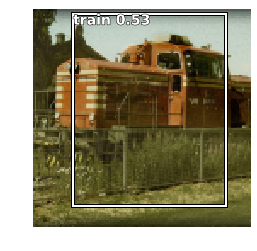

In [178]:
img,target = next(iter(data.valid_dl))
with torch.no_grad():
    output = learn.model(img)
    
idx = 0
img = data.valid_ds[idx][0]
show_preds(img, output, idx, detect_thresh=0.5, classes=data.classes)

In [175]:
def show_results(learn, start=0, n=5, detect_thresh=0.35, figsize=(10,25)):
    x,y = learn.data.one_batch(DatasetType.Valid, cpu=False)
    with torch.no_grad():
        z = learn.model.eval()(x)
    _,axs = plt.subplots(n, 2, figsize=figsize)
    for i in range(n):
        img,bbox = learn.data.valid_ds[start+i]
        img.show(ax=axs[i,0], y=bbox)
        show_preds(img, z, start+i, detect_thresh=detect_thresh, classes=learn.data.classes, ax=axs[i,1])

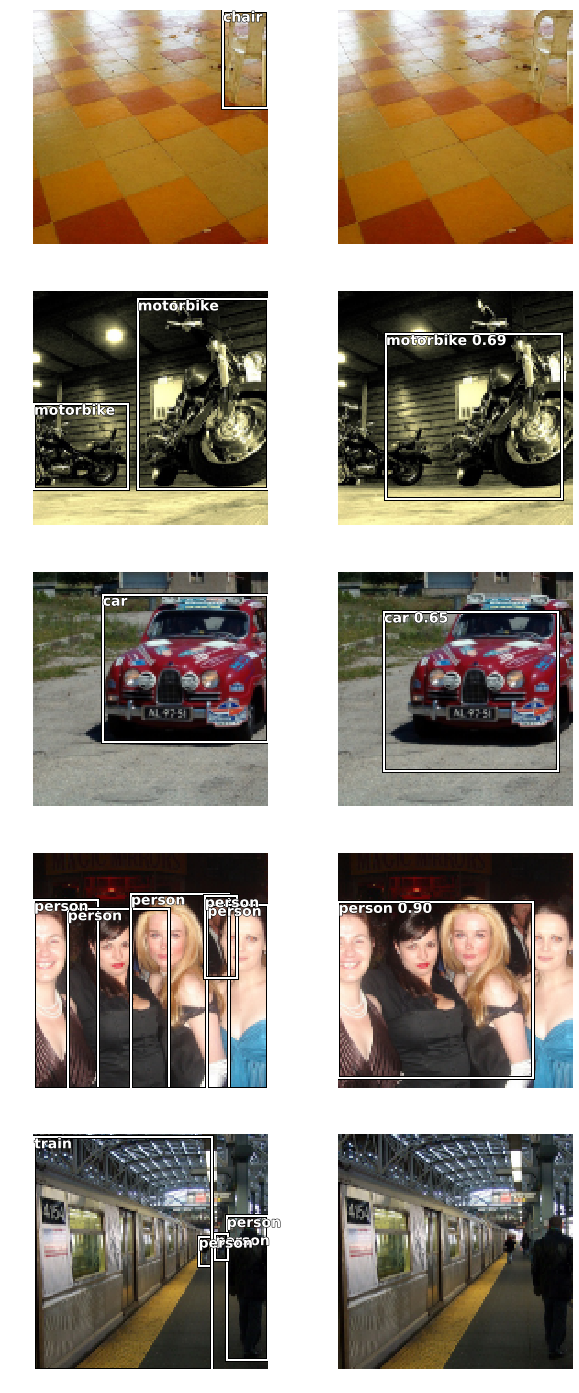

In [180]:
show_results(learn, start=10,detect_thresh=0.5)

## mAP


In [181]:
def get_predictions(output, idx, detect_thresh=0.05):
    bbox_pred, scores, preds = process_output(output, idx, detect_thresh)
    if len(scores) == 0: return [],[],[]
    to_keep = nms(bbox_pred, scores)
    if len(to_keep) == 0: return [],[],[]
    return bbox_pred[to_keep], preds[to_keep], scores[to_keep]

In [182]:
def compute_ap(precision, recall):
    "Compute the average precision for `precision` and `recall` curve."
    recall = np.concatenate(([0.], list(recall), [1.]))
    precision = np.concatenate(([0.], list(precision), [0.]))
    for i in range(len(precision) - 1, 0, -1):
        precision[i - 1] = np.maximum(precision[i - 1], precision[i])
    idx = np.where(recall[1:] != recall[:-1])[0]
    ap = np.sum((recall[idx + 1] - recall[idx]) * precision[idx + 1])
    return ap

In [185]:
def unpad(tgt_bbox, tgt_clas, pad_idx=0):
    i = torch.min(torch.nonzero(tgt_clas-pad_idx))
    return tlbr2cthw(tgt_bbox[i:]), tgt_clas[i:]-1+pad_idx
def compute_class_AP(model, dl, n_classes, iou_thresh=0.5, detect_thresh=0.35, num_keep=100):
    tps, clas, p_scores = [], [], []
    classes, n_gts = LongTensor(range(n_classes)),torch.zeros(n_classes).long()
    with torch.no_grad():
        for input,target in progress_bar(dl):
            output = model(input)
            for i in range(target[0].size(0)):
                bbox_pred, preds, scores = get_predictions(output, i, detect_thresh)
                tgt_bbox, tgt_clas = unpad(target[0][i], target[1][i])
                if len(bbox_pred) != 0 and len(tgt_bbox) != 0:
                    ious = IoU_values(bbox_pred, tgt_bbox)
                    max_iou, matches = ious.max(1)
                    detected = []
                    for i in range_of(preds):
                        if max_iou[i] >= iou_thresh and matches[i] not in detected and tgt_clas[matches[i]] == preds[i]:
                            detected.append(matches[i])
                            tps.append(1)
                        else: tps.append(0)
                    clas.append(preds.cpu())
                    p_scores.append(scores.cpu())
                n_gts += (tgt_clas.cpu()[:,None] == classes[None,:]).sum(0)
    tps, p_scores, clas = torch.tensor(tps), torch.cat(p_scores,0), torch.cat(clas,0)
    fps = 1-tps
    idx = p_scores.argsort(descending=True)
    tps, fps, clas = tps[idx], fps[idx], clas[idx]
    aps = []
    #return tps, clas
    for cls in range(n_classes):
        tps_cls, fps_cls = tps[clas==cls].float().cumsum(0), fps[clas==cls].float().cumsum(0)
        if tps_cls.numel() != 0 and tps_cls[-1] != 0:
            precision = tps_cls / (tps_cls + fps_cls + 1e-8)
            recall = tps_cls / (n_gts[cls] + 1e-8)
            aps.append(compute_ap(precision, recall))
        else: aps.append(0.)
    return aps

In [186]:
L = compute_class_AP(learn.model, data.valid_dl, data.c-1)

In [187]:
for ap,cl in zip(L, data.classes[1:]): print(f'{cl}: {ap:.6f}')

aeroplane: 0.333155
bicycle: 0.150523
bird: 0.188501
boat: 0.017747
bottle: 0.017292
bus: 0.142016
car: 0.194164
cat: 0.367156
chair: 0.008868
cow: 0.053189
diningtable: 0.099948
dog: 0.231199
horse: 0.227591
motorbike: 0.197994
person: 0.126194
pottedplant: 0.024233
sheep: 0.034383
sofa: 0.123995
train: 0.385270
tvmonitor: 0.081682


============================

实验性代码

In [49]:
img, tgt = data.one_batch()

In [50]:
img.shape, len(tgt), tgt[0].shape, tgt[1].shape # 此处最多一张图片有10个类别

(torch.Size([64, 3, 128, 128]),
 2,
 torch.Size([64, 16, 4]),
 torch.Size([64, 16]))

In [51]:
img,target = next(iter(data.valid_dl))
with torch.no_grad():
    output = learn.model(img)

In [52]:
clas_preds, bbox_preds, sizes = output
bbox_tgts,clas_tgts = target
# 3069 个anchor
clas_preds.shape, bbox_preds.shape

(torch.Size([64, 3069, 21]), torch.Size([64, 3069, 4]))

In [53]:
crit._create_anchors(sizes, clas_preds.device)

In [54]:
for (clas_pred, bbox_pred, clas_tgt, bbox_tgt) in zip(clas_preds, bbox_preds, clas_tgts, bbox_tgts):
    break

In [55]:
clas_pred.shape, bbox_pred.shape, clas_tgt.shape, bbox_tgt.shape

(torch.Size([3069, 21]),
 torch.Size([3069, 4]),
 torch.Size([28]),
 torch.Size([28, 4]))

In [56]:
target[0].shape, target[1].shape # 最多的一张图上有28个bbox

(torch.Size([64, 28, 4]), torch.Size([64, 28]))

In [57]:
bbox_tgt, clas_tgt = crit._unpad(bbox_tgt, clas_tgt)
bbox_tgt.shape, clas_tgt.shape # 原来只有一个类别

(torch.Size([1, 4]), torch.Size([1]))

In [58]:
bbox_tgt, clas_tgt

(tensor([[-1.5235e-01,  1.0469e-03,  1.2632e+00,  1.9979e+00]], device='cuda:0'),
 tensor([18], device='cuda:0'))

In [59]:
matches = match_anchors(crit.anchors, bbox_tgt)
matches # len(matches) = anchors 数量

tensor([-1, -1, -1,  ..., -1, -1, -1], device='cuda:0')

In [60]:
bbox_mask = matches >= 0 # 都是false，没有匹配上的，不计算
len(bbox_mask)

3069

In [61]:
matches.add_(1) # +1 将-1转换为0 background
clas_tgt = clas_tgt + 1 # +1 将-1转换为0 background
clas_mask = matches >= 0

In [62]:
# clas_pred 每个 anchor 的类别预测
clas_pred = clas_pred[clas_mask]
clas_pred.shape

torch.Size([3057, 21])

In [63]:
print(clas_tgt.shape)
# 加上一个0类别
clas_tgt = torch.cat([clas_tgt.new_zeros(1).long(), clas_tgt])
print(clas_tgt.shape)

torch.Size([1])
torch.Size([2])


In [64]:
clas_tgt = clas_tgt[matches[clas_mask]]

类别误差
$$
\mathrm{FL}\left(p_{\mathrm{t}}\right)=-\alpha_{\mathrm{t}}\left(1-p_{\mathrm{t}}\right)^{\gamma} \log \left(p_{\mathrm{t}}\right)
$$

In [65]:
clas_pred.shape, clas_tgt.shape

(torch.Size([3057, 21]), torch.Size([3057]))

In [67]:
encoded_tgt = encode_class(clas_tgt, clas_pred.size(1))

In [69]:
encoded_tgt, encoded_tgt.shape

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0'),
 torch.Size([3057, 21]))

In [70]:
# clas_pred

tensor([[-4., -4., -4.,  ..., -4., -4., -4.],
        [-4., -4., -4.,  ..., -4., -4., -4.],
        [-4., -4., -4.,  ..., -4., -4., -4.],
        ...,
        [-4., -4., -4.,  ..., -4., -4., -4.],
        [-4., -4., -4.,  ..., -4., -4., -4.],
        [-4., -4., -4.,  ..., -4., -4., -4.]], device='cuda:0')